In [37]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [25]:
data_path = r'C:\Users\azizh\OneDrive\Bureau\TekSpire\Data\PredPriceData\Dataset\PcSales.csv'
data = pd.read_csv(data_path)

data.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20


In [26]:
data.shape

(1302, 13)

In [27]:
data.isna().sum()

Manufacturer                  0
Model Name                    0
Category                      0
Screen Size                   0
Screen                        0
CPU                           0
RAM                           0
Storage                       0
GPU                           0
Operating System              0
Operating System Version    170
Weight                        0
Price                         0
dtype: int64

In [28]:
data = data.drop(columns=['Operating System Version'])

In [29]:
data.columns.tolist()

['Manufacturer',
 'Model Name',
 'Category',
 'Screen Size',
 'Screen',
 'CPU',
 'RAM',
 'Storage',
 'GPU',
 'Operating System',
 'Weight',
 'Price']

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Manufacturer      1302 non-null   object 
 1   Model Name        1302 non-null   object 
 2   Category          1302 non-null   object 
 3   Screen Size       1302 non-null   object 
 4   Screen            1302 non-null   object 
 5   CPU               1302 non-null   object 
 6   RAM               1302 non-null   object 
 7   Storage           1302 non-null   object 
 8   GPU               1302 non-null   object 
 9   Operating System  1302 non-null   object 
 10  Weight            1302 non-null   object 
 11  Price             1302 non-null   float64
dtypes: float64(1), object(11)
memory usage: 122.2+ KB


<Axes: xlabel='count', ylabel='Manufacturer'>

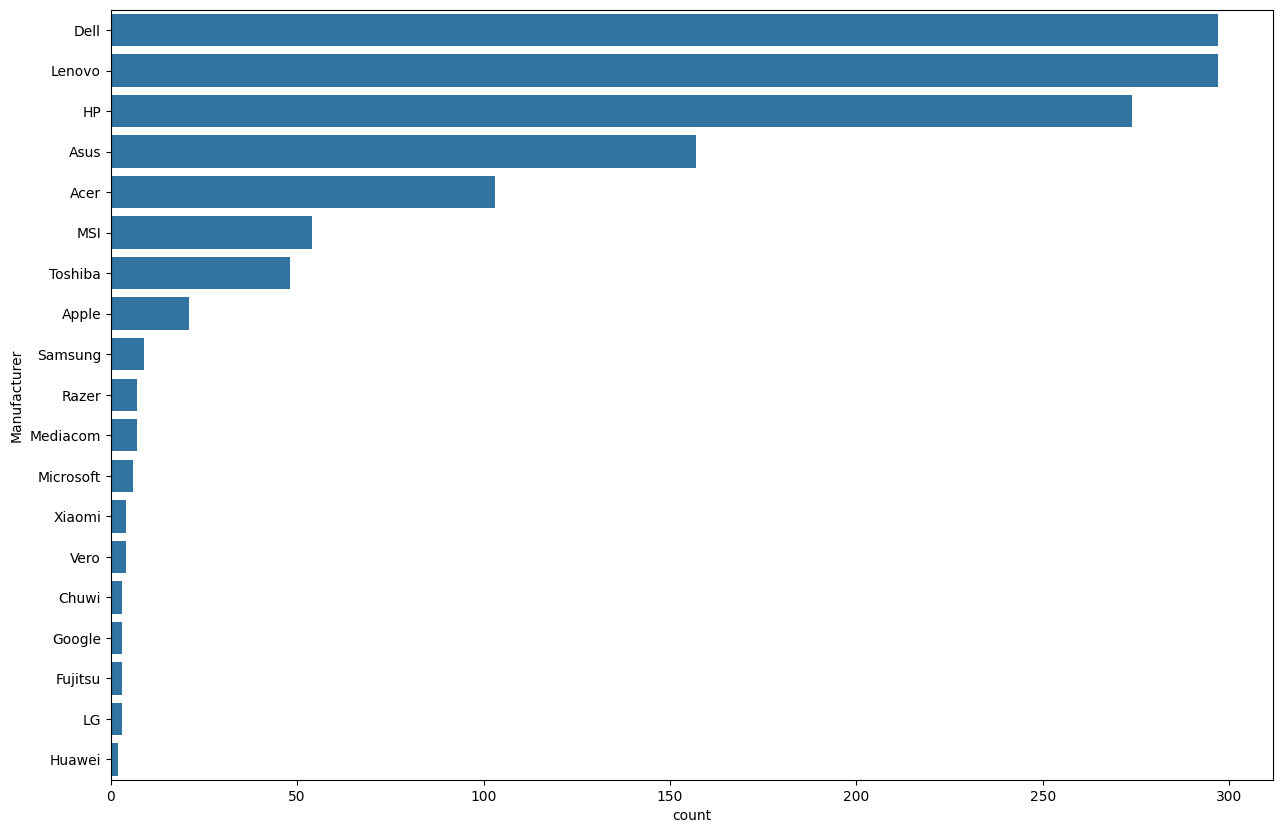

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))
sns.countplot(y='Manufacturer', data=data, order=data.Manufacturer.value_counts().index)

In [32]:
columns_to_use = ['Manufacturer','Model Name', 'CPU', 'RAM','Storage' ,'GPU', 'Price']
data = data[columns_to_use]


In [33]:
X = data.drop(columns=['Price'])
y = data['Price']

In [34]:
cat_cols = [
    'Manufacturer',
    'Model Name',
    'CPU',
    'RAM',
    'Storage',
    'GPU'
]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
# Dictionnaire des modèles
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
}

results = []

for name, model in models.items():
    # Pipeline : préprocessing + modèle
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Cross-validation (R2) sur X_train
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    
    # Entraînement sur tout le train
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    results.append({
        'Model': name,
        'CV mean': round(cv_score.mean(), 6),
        'CV std': round(cv_score.std(), 6),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    })

# Convertir en DataFrame et trier
result_df = pd.DataFrame(results)
result_df = result_df.sort_values(by='r2', ascending=False)
result_df

,Model,CV mean,CV std,mse,mae,r2
2,KNN,0.739383,0.025472,9.782620e+12,2.044608e+06,0.760246
3,Random Forest,0.763895,0.053900,9.796774e+12,1.935455e+06,0.759899
1,Decision Tree,0.690119,0.057856,1.073521e+13,2.005062e+06,0.736899
0,Linear Regression,0.660135,0.120358,1.279928e+13,2.046364e+06,0.686313


In [39]:
result_df.loc[result_df['r2'] == result_df['r2'].max(), 'Model' ]

2    KNN
Name: Model, dtype: object

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline avec KNN
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # ton ColumnTransformer
    ('regressor', KNeighborsRegressor())
])

# Paramètres à tester pour KNN
param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 9],  # nombre de voisins à tester
    'regressor__weights': ['uniform', 'distance'],  # uniform = pondération égale, distance = proche influence plus
    'regressor__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

# GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entraînement sur tes données
grid.fit(X_train, y_train)

# Meilleur pipeline
best_pipeline = grid.best_estimator_

# Résultats
print("Best params:", grid.best_params_)
print("Best CV R2:", grid.best_score_)


Best params: {'regressor__n_neighbors': 7, 'regressor__p': 1, 'regressor__weights': 'distance'}
Best CV R2: 0.7557511685668928


In [41]:
# Prédictions
y_pred_train = best_pipeline.predict(X_train)
y_pred_test = best_pipeline.predict(X_test)

# R²
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# MSE
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Affichage
print(f"Train R2: {r2_train:.4f}")
print(f"Test R2: {r2_test:.4f}")
print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")

Train R2: 0.9957
Test R2: 0.7861
Train MSE: 162472617486.48
Test MSE: 8727733994682.31


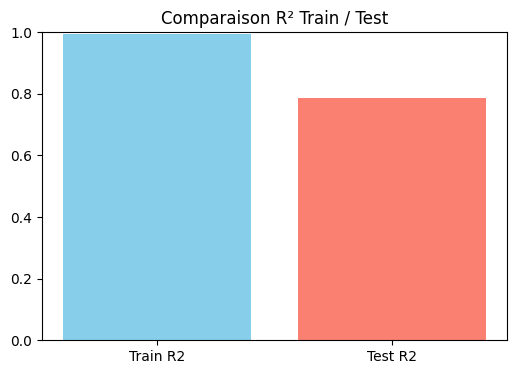

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(["Train R2", "Test R2"], [r2_train, r2_test], color=['skyblue', 'salmon'])
plt.title("Comparaison R² Train / Test")
plt.ylim(0,1)
plt.show()

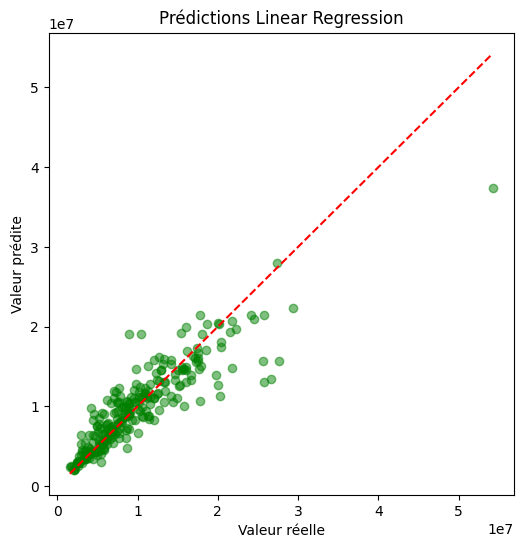

In [43]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ligne y=x
plt.xlabel("Valeur réelle")
plt.ylabel("Valeur prédite")
plt.title("Prédictions Linear Regression")
plt.show()

In [44]:
joblib.dump(best_pipeline, "best_knn_model.pkl")

['best_knn_model.pkl']

In [47]:
import pandas as pd
import joblib

# Charger le modèle sauvegardé
best_pipeline = joblib.load("best_knn_model.pkl")

# Exemple : plusieurs produits à tester
test_samples = pd.DataFrame({
    'Manufacturer': ['Dell', 'HP', 'Asus'],
    'Model Name': ['Inspiron 15', 'Pavilion 14', 'ROG Zephyrus'],
    'CPU': ['Intel i5', 'Intel i7', 'AMD Ryzen 7'],
    'RAM': ['16GB', '8GB', '32GB'],
    'Storage': ['512GB SSD', '256GB SSD', '1TB SSD'],
    'GPU': ['NVIDIA GTX 1650', 'Intel UHD', 'NVIDIA RTX 3060']
})

# Prédiction avec le pipeline KNN
predictions = best_pipeline.predict(test_samples)

# Ajouter les prédictions au DataFrame
test_samples['Predicted price'] = predictions

# Afficher le résultat
pd.options.display.float_format = '{:,.2f}'.format
print(test_samples)


  Manufacturer    Model Name          CPU   RAM    Storage              GPU  \
0         Dell   Inspiron 15     Intel i5  16GB  512GB SSD  NVIDIA GTX 1650   
1           HP   Pavilion 14     Intel i7   8GB  256GB SSD        Intel UHD   
2         Asus  ROG Zephyrus  AMD Ryzen 7  32GB    1TB SSD  NVIDIA RTX 3060   

   Predicted price  
0    18,424,224.00  
1    12,239,965.03  
2    28,516,644.00  
